# Combined Test for Interface Overlay

This notebook will show how to use the Boolean builder, pattern builder, and Finite State Machine (FSM) builder together at the same time.

### Step 1: Overlay management

Download the overlay and import all the required libraries.

In [1]:
from pynq import Overlay
from pynq.lib.intf import FSMBuilder
from pynq.lib.intf import PatternBuilder
from pynq.lib.intf import BooleanBuilder
from pynq.lib.intf import Intf
from pynq.lib.intf import ARDUINO

Overlay('interface.bit').download()
microblaze_intf = Intf(ARDUINO)

### Step 2: Instantiate FSM builder

With the Microblaze interface instance ready, we will first deploy an FSM builder.

To make the Boolean builder, pattern builder, and FSM builder working together, the parameter `use_analyzer` must be `True` and the parameter `num_analyzer_samples` should be the same value for all the builders. In this example, we analyze 128 samples for all the builders.

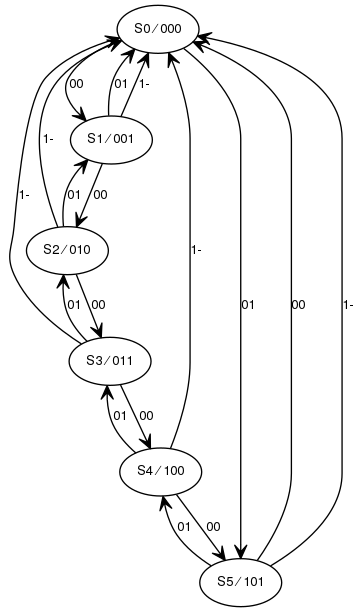

In [2]:
fsm_spec = {'inputs': [('reset','D0'), ('direction','D1')],
        'outputs': [('bit2','D3'), ('bit1','D4'), ('bit0','D5')],
        'states': ['S0', 'S1', 'S2', 'S3', 'S4', 'S5'],
        'transitions': [['00', 'S0', 'S1', '000'],
                        ['01', 'S0', 'S5', '000'],
                        ['00', 'S1', 'S2', '001'],
                        ['01', 'S1', 'S0', '001'],
                        ['00', 'S2', 'S3', '010'],
                        ['01', 'S2', 'S1', '010'],
                        ['00', 'S3', 'S4', '011'],
                        ['01', 'S3', 'S2', '011'],
                        ['00', 'S4', 'S5', '100'],
                        ['01', 'S4', 'S3', '100'],
                        ['00', 'S5', 'S0', '101'],
                        ['01', 'S5', 'S4', '101'],
                        ['1-', '*',  'S0', '']]}

fsm = FSMBuilder(microblaze_intf, fsm_spec, num_analyzer_samples=128)
fsm.show_state_diagram()

### Step 3: Instantiate pattern builder

In [3]:
loopback_test = {'signal': [
    ['stimulus',
        {'name': 'clk6',  'pin': 'D6', 'wave': 'l...h...' * 16},
        {'name': 'clk7',  'pin': 'D7', 'wave': 'l.......h.......' * 8},
        {'name': 'clk8',  'pin': 'D8', 'wave': 'lh' * 16}, 
        {'name': 'clk9',  'pin': 'D9', 'wave': 'l.h.' * 32}, 
        {'name': 'clk10', 'pin': 'D10', 'wave': 'l...h...' * 16},
        {'name': 'clk11', 'pin': 'D11', 'wave': 'l.......h.......' * 8},
        {'name': 'clk12', 'pin': 'D12', 'wave': 'lh' * 8},
        {'name': 'clk13', 'pin': 'D13', 'wave': 'l.h.' * 32}], 
      
    ['analysis',
        {'name': 'clk6',  'pin': 'D6'},
        {'name': 'clk7',  'pin': 'D7'},
        {'name': 'clk8',  'pin': 'D8'},
        {'name': 'clk9',  'pin': 'D9'},
        {'name': 'clk10', 'pin': 'D10'},
        {'name': 'clk11', 'pin': 'D11'},
        {'name': 'clk12', 'pin': 'D12'},
        {'name': 'clk13', 'pin': 'D13'}]], 

    'foot': {'tock': 1, 'text': 'Loopback Test'},
    'head': {'tick': 1, 'text': 'Loopback Test'}}

After instantiation of the pattern builder, users can immediately display the waveform. However, the `analysis` group of the waveform will be empty, since the pattern builder has not been run yet.

If the wave lanes are not of the same length, they will get extended automatically.

In [4]:
pb = PatternBuilder(microblaze_intf, loopback_test, 
                    stimulus_name='stimulus', analysis_name='analysis',
                    num_analyzer_samples=128)
pb.waveform.display()

WaveLane clk8 extended to 128 tokens.
WaveLane clk12 extended to 128 tokens.


### Step 4: Instantiate Boolean builder
The Boolean expressions can also have on-board LEDs as output pins, and push buttons specified as input pins. However, LEDs and push buttons are non-traceable pins so they will not show in the waveform display.

In [5]:
expressions = ["LD0 = D14",
               "LD1 = D15",
               "D18 = PB0 | PB1",
               "D19 = D16 & D17"]
bbs = [BooleanBuilder(microblaze_intf, expr=expr, 
                      num_analyzer_samples=128) for expr in expressions]

### Step 5: Running builders together

For the FSM builder:

* Connect both `D0` and `D1` to `GND`, so the counter will count up, or:
* Connect `D0` to `GND`, and `D1` to `Vref` for the counter to count down.

Users can configure, arm, and run the builders. The builders can be run together by calling `microblaze_intf.run()`.

Users can also manually check the outputs of the Boolean builders.

In [6]:
pb.arm() 
fsm.arm()
for builder in bbs:
    builder.arm()

microblaze_intf.start()

In [7]:
fsm.show_waveform()

In [8]:
pb.show_waveform()

In [9]:
for builder in bbs:
    builder.show_waveform()

### Step 6: Stop the generators

Note that calling `microblaze_intf.stop()` is equivalent to calling individual `stop()` method of each builder.

The trace buffer will also get cleared automatically.

In [10]:
microblaze_intf.stop()